
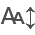

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

n_variables  n_samples  real_entropy  gcmi_entropy  npeet_entropy
0              3         10      4.044584      6.183538       5.088746
1              3         15      4.044584      6.432875       4.626040
2              3        100      4.044584      5.297707       4.840849
3              3        150      4.044584      5.824732       5.275101
4              3       1000      4.044584      5.887104       5.000818
..           ...        ...           ...           ...            ...
955            6      15000      6.863104      9.840720      10.597883
956            6     100000      6.863104      9.832405      10.566824
957            6     150000      6.863104      9.843232      10.567504
958            6    1000000      6.863104      9.857981      10.554389
959            6    1500000      6.863104      9.856132      10.547632

[960 rows x 5 columns]

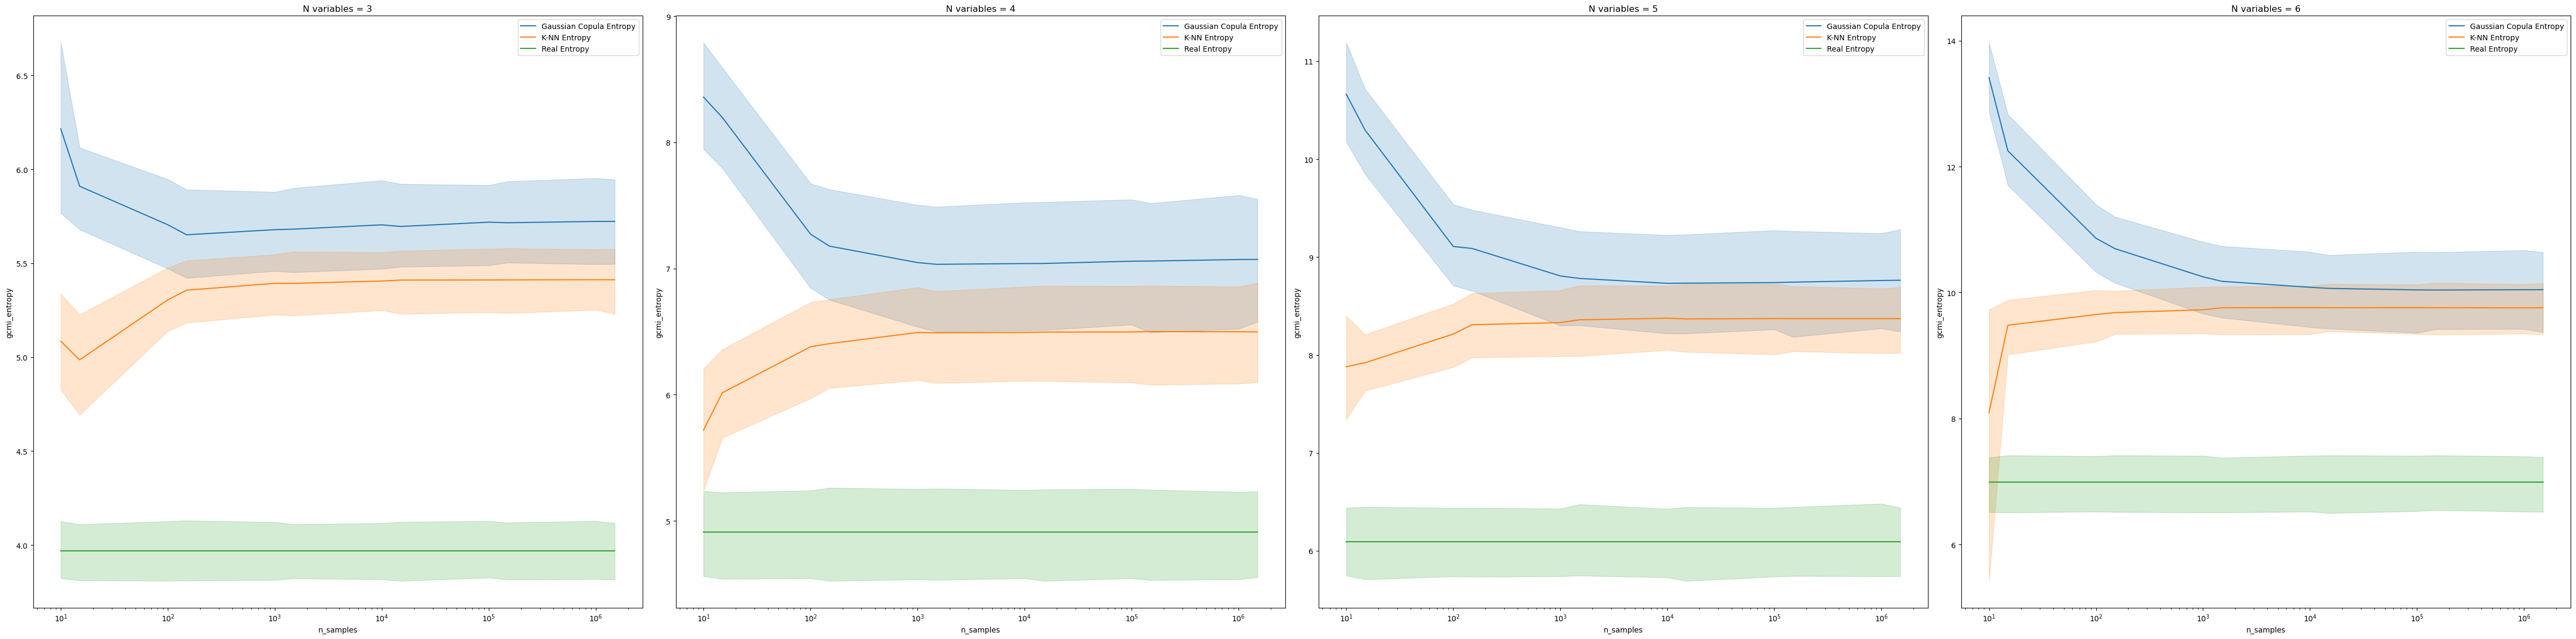

In [2]:
df = pd.read_csv('../benchmarking/results/estimators_error_repeat-20.tsv', sep='\t')
display(df)
df_variables_groups = df.groupby('n_variables')

fig, axes = plt.subplots(1, len(df_variables_groups), figsize=(12*len(df_variables_groups), 12))

for ax, (n_variables, df_group) in zip(axes, df_variables_groups):
    sns.lineplot(data=df_group, x='n_samples', y='gcmi_entropy', label='Gaussian Copula Entropy', ax=ax)
    sns.lineplot(data=df_group, x='n_samples', y='npeet_entropy', label='K-NN Entropy', ax=ax)
    sns.lineplot(data=df_group, x='n_samples', y='real_entropy', label='Real Entropy', ax=ax)

    ax.set_title(f'N variables = {n_variables}')
    ax.set_xscale('log')

plt.legend()
plt.tight_layout()
plt.show()

In [54]:
import numpy as np

from Oinfo.oinfo_general import o_information

def gaussian_entropy(covariance):
    n_variables = covariance.shape[0]
    cov_det = np.linalg.det(covariance) 
    return 0.5 * np.log((2 * np.pi * np.e)**n_variables * cov_det)

def generate_covariance_matrix(dim, x):
    """
    Generate a covariance matrix that interpolates between total independence and full dependence
    of the variables based on parameter x.
    
    Parameters:
    dim (int): Dimension of the covariance matrix.
    x (float): Interpolation parameter where 0 means independent and 1 means fully dependent.
    
    Returns:
    np.array: A dim x dim covariance matrix.
    """
    variances = np.ones(dim)  # Default variance for each variable is 1
    
    # Create a diagonal matrix with the variances
    covariance_matrix = np.diag(variances)
    
    # Adjust off-diagonal elements
    for i in range(dim):
        for j in range(i + 1, dim):
            # Set off-diagonal elements based on x
            covariance = x * np.sqrt(variances[i] * variances[j])
            covariance_matrix[i, j] = covariance_matrix[j, i] = covariance
    
    return covariance_matrix

def o_information(covariance: np.ndarray):
    """
    Calculate the O-information for a given dataset.

    Args:
        X (np.ndarray): A 2D array representing multivariate features (n_samples, n_variables).
        entropy_func (callable): Function to compute entropy of the dataset of shape (n_samples, n_variables).
        single_exclusions_mask (np.ndarray): a matrix of all Trues but the diagonal with shape (n_variable, n_variables) to exclude one variable at a time. Optional, if None, the matrix is calculated
        individual_entropies (np.ndarray): a 1D vector of size n_variables with the individual entropies of each variable in X. individual_entropies[i] is equal to entropy_func(X[:,i]). Optional, if None, the individual entropies calculated

    Returns:
        float: Computed O-information for the dataset.
    """

    N = covariance.shape[1]

    single_exclusions_mask = (np.ones((N, N)) - np.eye(N)).astype(bool)

    # H(X)
    system_entropy = gaussian_entropy(covariance)

    # H(X1), ..., H(Xn)
    individual_entropies = np.array([gaussian_entropy(covariance[[idx]][:,[idx]]) for idx in range(N)])

    # H(X-1), ..., H(X-n)
    single_exclusion_entropies = np.array([gaussian_entropy(covariance[idxs][:,idxs]) for idxs in single_exclusions_mask])

    return (N - 2) * system_entropy + (individual_entropies - single_exclusion_entropies).sum()

def measure(x):
    cov = generate_covariance_matrix(3, x)
    return o_information(cov)


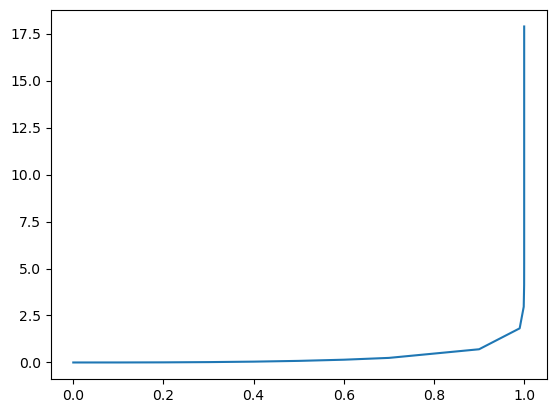

In [65]:
# 1-10**-6
X = [10**-x for x in reversed(range(1,17))] + [0.1*x for x in range(2,8)] + [1-10**-x for x in range(1,17)]
Y = [measure(x) for x in X]

sns.lineplot(x=X, y=Y)
plt.show()